In [77]:
#import librarires
import numpy as np

In [78]:
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import joblib
from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [79]:
pd.set_option("display.max_columns",None)

In [80]:
sklearn.set_config(transform_output="default")

In [81]:
train_df=pd.read_csv("data/train.csv")
val_df=pd.read_csv("data/val.csv")
test_df=pd.read_csv("data/test.csv")

In [82]:
 def split_data(data):
     X=data.drop(columns="price")
     y=data.price.copy()
     return X,y
X_train , y_train = split_data(train_df)    
X_val , y_val=split_data(val_df)
X_test,y_test=split_data(test_df)

In [83]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info


In [84]:
print(X_train.shape , y_train.shape)

(640, 9) (640,)


In [85]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [86]:
num_cols = ["duration","total_stops"]
dt_cols = ["date_of_journey","dep_time","arrival_time"]
cat_cols = [col  for col in X_train.columns if (col not in num_cols) & (col not in dt_cols)]

In [87]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [88]:
num_transformer = Pipeline(steps=[
    ("imputer" , SimpleImputer(strategy="median")),
    ("scaler" , StandardScaler())
])

cat_transformer= Pipeline([
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False , handle_unknown="ignore"))
])

doj_transformer=Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"],format="mixed")),
    ("scaler",StandardScaler())
])
time_transformer=Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["hour","minute"],format="mixed")),
    ("scaler",StandardScaler())
])

In [89]:
preprocessor = ColumnTransformer(transformers=[
    ("num",num_transformer,num_cols),
    ("cat",cat_transformer,cat_cols),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time",time_transformer,["dep_time","arrival_time"])
])

In [90]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

In [91]:
#Model Selection
algorithm = {
    "Linear Regression" : LinearRegression() , 
    "Support Vector Machine" : SVR(),
    "Random Forest" : RandomForestRegressor(n_estimators=10),
    "XG Boost" : XGBRegressor(n_estimators=10)
}

In [92]:
data = pd.concat([train_df,val_df],axis=0)
data
X_data , y_data = split_data(data)
X_data.shape , y_data.shape

((800, 9), (800,))

In [93]:
def plot_curve(sizes , mean_scores , std_scores,label,ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label= label
    )
    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores , 
        y2= mean_scores + std_scores , 
        alpha = 0.5
    )

In [94]:
def plot_learning_curves(name , algorithm , figsize=(12,4)):
    model = Pipeline(steps=[
        ("pre",preprocessor),
        ("alg",algorithm)
    ])

    train_sizes , train_scores, test_scores = learning_curve(
        estimator = model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    mean_train_scores = np.mean(train_scores , axis=1)
    std_train_scores = np.std(train_scores,axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores , axis=1)
    std_test_scores = np.std(test_scores,axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"


    fig , ax = plt.subplots(figsize=figsize)

    plot_curve(train_sizes ,
               mean_train_scores ,
               std_train_scores,
               f"Train({test_score})",
               ax)

    plot_curve(train_sizes ,
               mean_test_scores ,
               std_test_scores,
               f"Test({test_score})",
               ax)
    ax.set(xlabel="Training set size" , ylabel="R-square ",title = name)

    ax.legend(loc="lower right")

    plt.show()



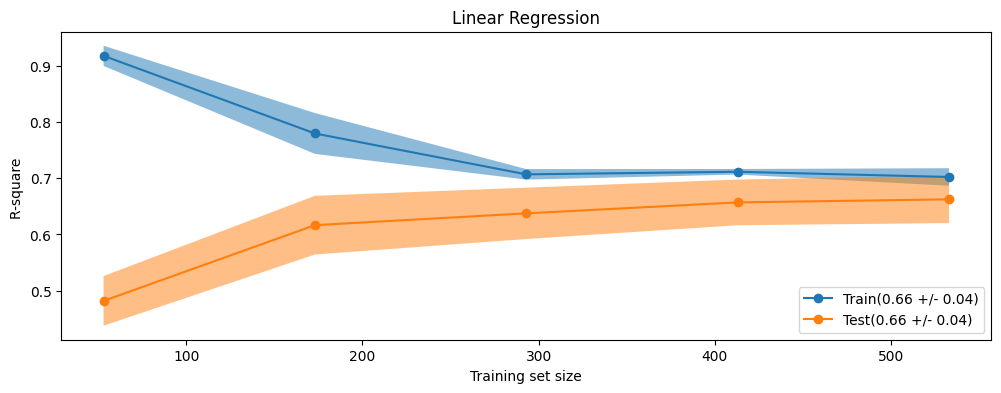

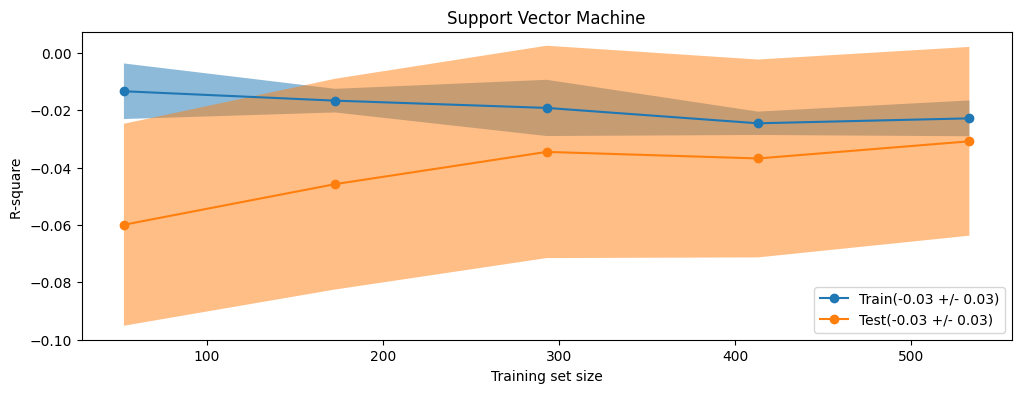

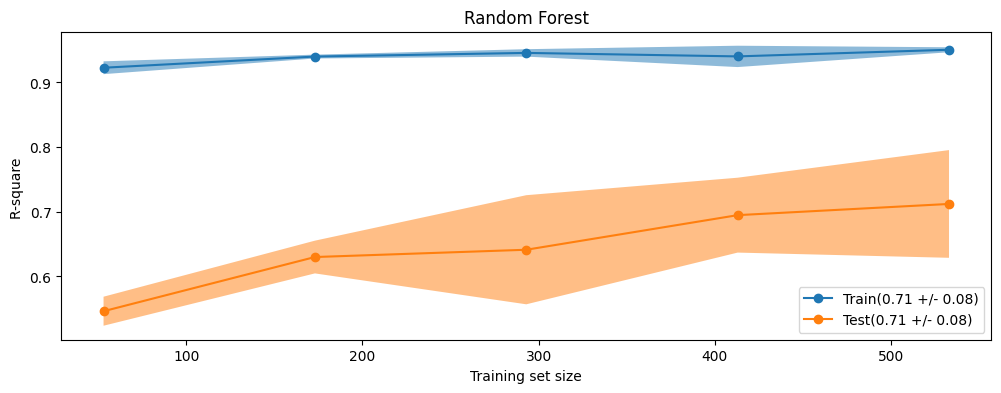

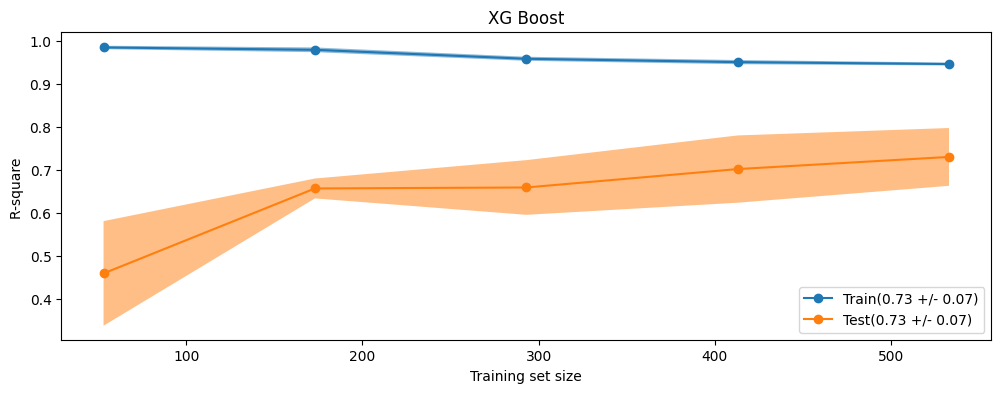

In [95]:
for name , alg  in algorithm.items():
    plot_learning_curves(name , alg)

In [96]:
model = Pipeline(steps=[
    ("pre" , preprocessor),

    ("rf" , RandomForestRegressor(n_estimators=10))
    
])

In [97]:
model.fit(X_data , y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [98]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)

In [99]:
print(f"R2 score on training data is {evaluate_model(X_data , y_data)}")

R2 score on training data is 0.9552170367703965


In [100]:
print(f"R2 score on test data is {evaluate_model(X_test , y_test)}")

R2 score on test data is 0.7044677330162442


In [101]:
joblib.dump(model , "model.joblib")

['model.joblib']

In [102]:
saved_model = joblib.load("model.joblib")

In [103]:
y_pred=saved_model.predict(X_test)
r2_score(y_test,y_pred)

0.7044677330162442